# Introdução
Neste trabalho, aplicaremos uma Rede Neural Convolucional (CNN) no dataset **CIFAR-10**, que é um conjunto de dados padrão em problemas de classificação de imagens. O objetivo é treinar um modelo capaz de reconhecer imagens pertencentes a 10 diferentes categorias (avião, automóvel, pássaro, gato, cervo, cachorro, sapo, cavalo, navio e caminhão), com base em seus padrões visuais.

Utilizaremos o Keras com TensorFlow para treinar uma CNN do zero e ao final simularemos um cenário de produção salvando o modelo treinado.


# Análise do Dataset
O dataset CIFAR-10 contém 60.000 imagens coloridas de 32x32 pixels em 10 classes diferentes, com 6.000 imagens por classe. Ele é dividido automaticamente pelo Keras em 50.000 imagens de treino e 10.000 imagens de teste.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carregar dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalizar os dados
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encoding dos rótulos
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Formato do x_train:", x_train.shape)
print("Formato do y_train:", y_train.shape)


Formato do x_train: (50000, 32, 32, 3)
Formato do y_train: (50000, 10)


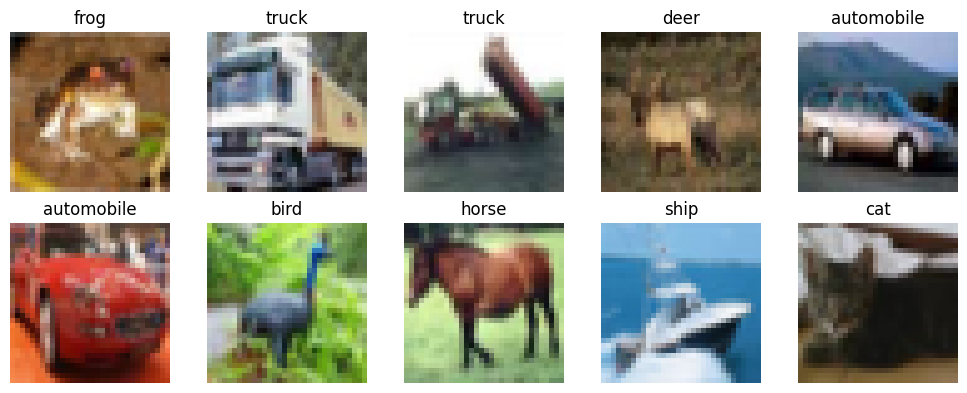

In [9]:
# Visualizar algumas imagens
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Aumento de Dados (Data Augmentation)
Aplicamos técnicas de data augmentation para aumentar a robustez do modelo com rotações, zoom e espelhamento horizontal.


In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)


# Construção da CNN
A arquitetura da rede inclui camadas convolucionais, max pooling, dropout e densas.


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\T-GAMER\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do Modelo
Utilizaremos 10 épocas e o gerador de dados aumentados.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=64
)


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2743 - loss: 1.9548 - val_accuracy: 0.4977 - val_loss: 1.4300
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4662 - loss: 1.4728 - val_accuracy: 0.5484 - val_loss: 1.2773
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5221 - loss: 1.3339 - val_accuracy: 0.5933 - val_loss: 1.1613
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5582 - loss: 1.2411 - val_accuracy: 0.6142 - val_loss: 1.1223
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5870 - loss: 1.1717 - val_accuracy: 0.6375 - val_loss: 1.0455
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6036 - loss: 1.1295 - val_accuracy: 0.6504 - val_loss: 1.0052
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6167 - loss: 1.0757 - val_accuracy: 0.6418 - val_loss: 1.0501
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6305 - loss: 1.0451 - val_accuracy: 0

In [13]:
# Avaliação final do modelo
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")


313/313 - 0s - 2ms/step - accuracy: 0.7228 - loss: 0.8059
Acurácia no conjunto de teste: 0.7228


# Simulação de Produção
Salvando o modelo treinado para uso futuro (ex: em uma API ou aplicação real).


In [14]:
import os
from pathlib import Path # Ajuda a lidar com caminhos de forma robusta

try:
    # Obtém o diretório home do usuário (funciona em Windows, Linux, macOS)
    home_directory = Path.home()
    
    # Define o caminho completo para o arquivo do modelo no diretório home
    # Por exemplo: C:\Users\SeuUsuario\modelo_cifar10.h5
    model_save_path = home_directory / "modelo_cifar10.h5"

    # Tenta salvar o modelo
    model.save(str(model_save_path)) # Convertemos para string pois model.save pode esperar string
    print(f"Modelo salvo com sucesso em: {model_save_path}")

except Exception as e:
    print(f"Erro ao salvar o modelo no diretório home: {e}")
    print("Verifique se há algum programa de segurança ou antivírus bloqueando.")

Modelo salvo com sucesso em: C:\Users\T-GAMER\modelo_cifar10.h5


In [15]:
import tensorflow as tf; print(tf.__version__)

2.16.1


### Indicadores para relatório

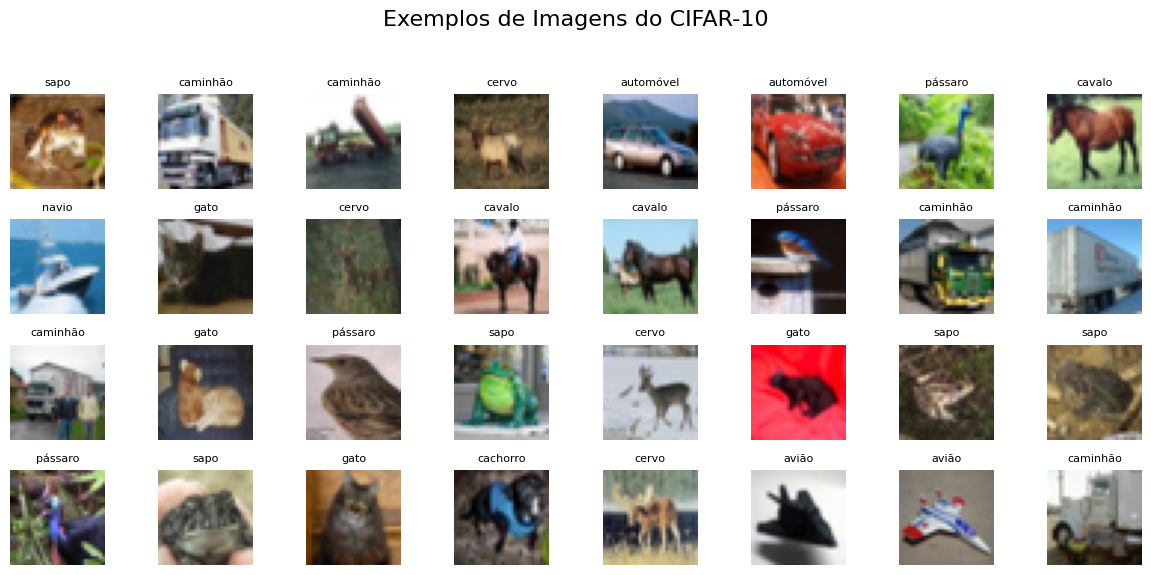

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10

# Carrega o dataset (se não estiver carregado)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Nomes das classes
CLASS_NAMES = [
    "avião", "automóvel", "pássaro", "gato", "cervo",
    "cachorro", "sapo", "cavalo", "navio", "caminhão"
]

# Função para exibir imagens (pode ser adaptada do seu notebook)
def plot_images(images, labels, class_names, num_rows=4, num_cols=8, title="Exemplos de Imagens do CIFAR-10"):
    plt.figure(figsize=(num_cols * 1.5, num_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]], fontsize=8)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout para o suptitle
    plt.show()

# Exibir as primeiras 32 imagens do conjunto de treinamento
plot_images(x_train, y_train, CLASS_NAMES, num_rows=4, num_cols=8)

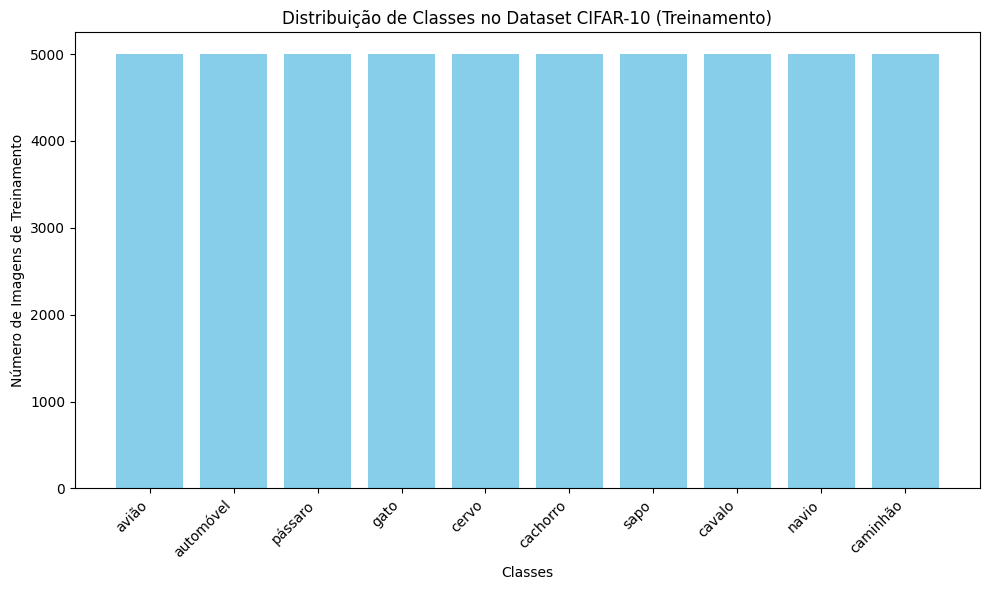

In [17]:
# Continuando do código anterior com x_train, y_train e CLASS_NAMES

# Contar a ocorrência de cada classe
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip([CLASS_NAMES[i] for i in unique], counts))

# Gerar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Número de Imagens de Treinamento")
plt.title("Distribuição de Classes no Dataset CIFAR-10 (Treinamento)")
plt.xticks(rotation=45, ha="right") # Rotaciona rótulos para melhor visualização
plt.tight_layout()
plt.show()

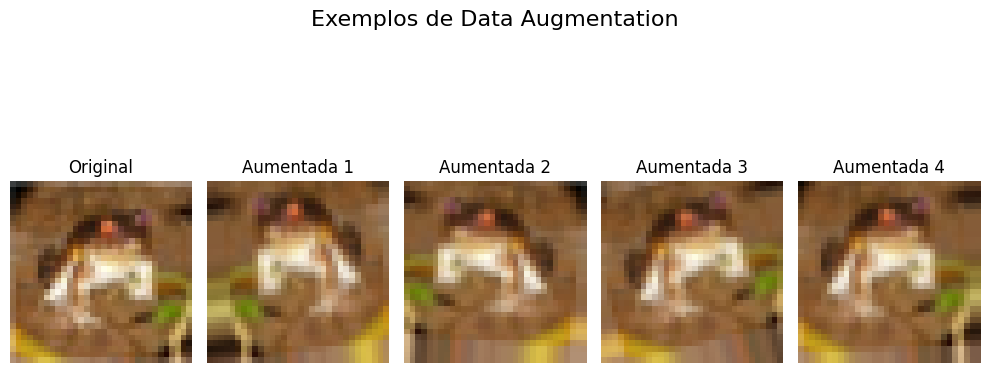

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Supondo que x_train já está carregado
# Pega a primeira imagem de avião (ou qualquer outra imagem que você queira)
sample_image = x_train[0] # Ou escolha uma imagem específica, ex: x_train[np.where(y_train == 0)[0][0]] para um avião

# Expande dimensão para simular um batch_size de 1
sample_image = np.expand_dims(sample_image, 0)

# Configura o ImageDataGenerator (use os mesmos parâmetros do seu notebook)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

plt.figure(figsize=(10, 5))
plt.suptitle("Exemplos de Data Augmentation", fontsize=16)

# Mostra a imagem original
plt.subplot(1, 5, 1)
plt.imshow(sample_image[0])
plt.title("Original")
plt.axis("off")

# Gera e mostra 4 imagens aumentadas
i = 2
for batch in datagen.flow(sample_image, batch_size=1):
    plt.subplot(1, 5, i)
    plt.imshow(batch[0].astype('uint8')) # Converter para uint8 para imshow
    plt.title(f"Aumentada {i-1}")
    plt.axis("off")
    i += 1
    if i > 5: # Gerar 4 imagens aumentadas
        break
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

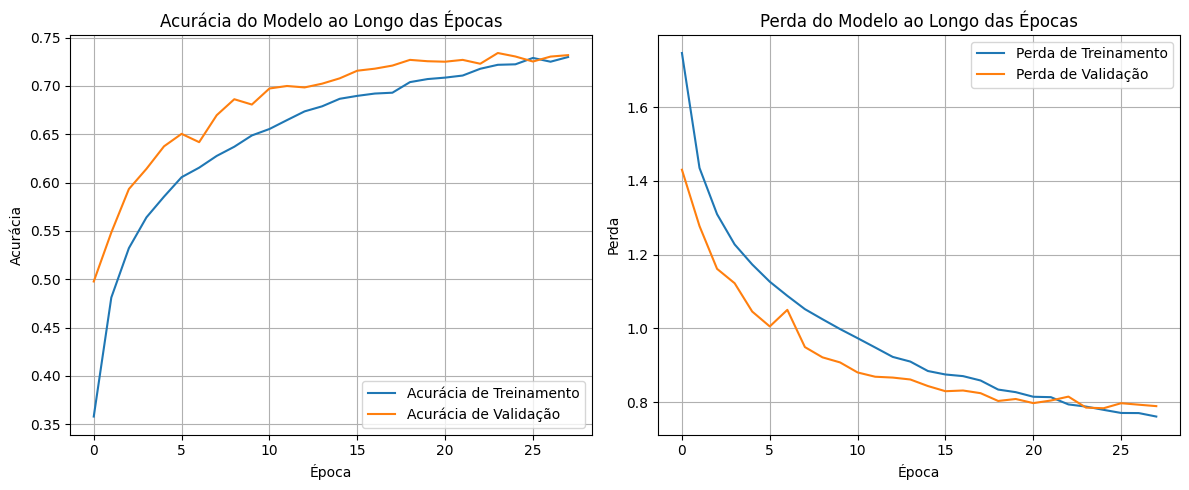

In [19]:
import matplotlib.pyplot as plt

# Supondo que 'history' é o objeto retornado por model.fit()

# Gráfico de Acurácia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


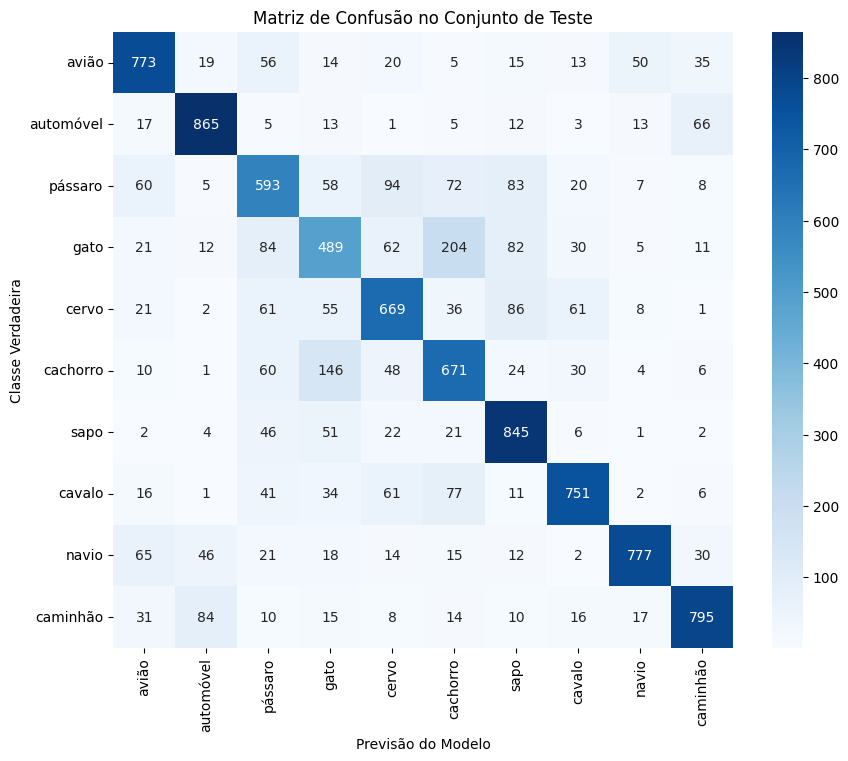

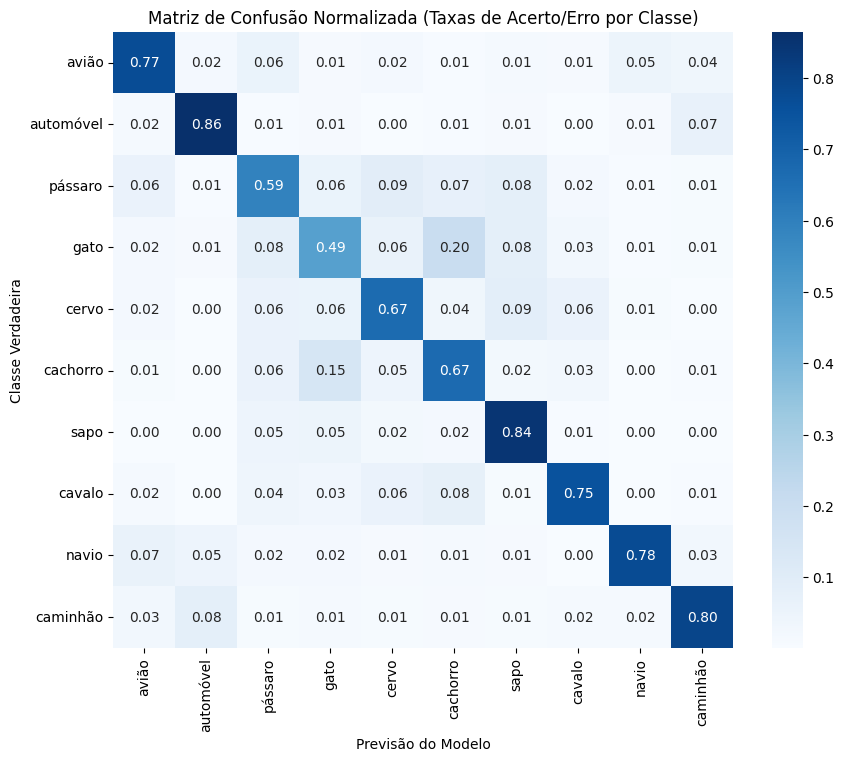

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10

# Supondo que você já carregou o x_test e y_test
# Se não, carregue:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Supondo que seu modelo já está treinado e carregado
# Se não, carregue:
# model = tf.keras.models.load_model('modelo_cifar10.h5')

# Nomes das classes (se ainda não definidos)
CLASS_NAMES = [
    "avião", "automóvel", "pássaro", "gato", "cervo",
    "cachorro", "sapo", "cavalo", "navio", "caminhão"
]

# Faça previsões no conjunto de teste
# O modelo.predict retorna probabilidades, precisamos da classe com maior probabilidade
y_pred_probs = model.predict(x_test / 255.0) # Não esqueça da normalização se usou no treino
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# As labels do y_test geralmente vêm como (N, 1), precisamos delas como (N,)
y_true_classes = y_test.flatten()

# Calcule a matriz de confusão
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plote a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Previsão do Modelo')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.show()

# Opcional: Para tornar mais fácil ver as taxas de erro, normalize a matriz
# Isso mostra a porcentagem de cada classe verdadeira que foi classificada como cada classe prevista
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Previsão do Modelo')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão Normalizada (Taxas de Acerto/Erro por Classe)')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# (Continuando do código da matriz de confusão com y_true_classes e y_pred_classes)

report = classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES)
print("Relatório de Classificação:\n", report)

Relatório de Classificação:
               precision    recall  f1-score   support

       avião       0.76      0.77      0.77      1000
   automóvel       0.83      0.86      0.85      1000
     pássaro       0.61      0.59      0.60      1000
        gato       0.55      0.49      0.52      1000
       cervo       0.67      0.67      0.67      1000
    cachorro       0.60      0.67      0.63      1000
        sapo       0.72      0.84      0.78      1000
      cavalo       0.81      0.75      0.78      1000
       navio       0.88      0.78      0.82      1000
    caminhão       0.83      0.80      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

